In [1]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# We need an extra "_d" because we're string-matching... and "theta*" could also match "d_theta*"
beh_name = np.array(['speed', 'pitch', 'roll', 'phi', 'theta', 'eyerad', 'd_pitch_d',
       'd_roll_d', 'd_phi_d', 'd_theta_d', 'd_eyerad_d', 'speed*pitch', 'speed*roll',
       'speed*phi', 'speed*theta', 'speed*eyerad', 'speed*d_pitch_d',
       'speed*d_roll_d', 'speed*d_phi_d', 'speed*d_theta_d', 'speed*d_eyerad_d',
       'pitch*roll', 'pitch*phi', 'pitch*theta', 'pitch*eyerad',
       'pitch*d_pitch_d', 'pitch*d_roll_d', 'pitch*d_phi_d', 'pitch*d_theta_d',
       'pitch*d_eyerad_d', 'roll*phi', 'roll*theta', 'roll*eyerad',
       'roll*d_pitch_d', 'roll*d_roll_d', 'roll*d_phi_d', 'roll*d_theta_d',
       'roll*d_eyerad_d', 'phi*theta', 'phi*eyerad', 'phi*d_pitch_d',
       'phi*d_roll_d', 'phi*d_phi_d', 'phi*d_theta_d', 'phi*d_eyerad_d', 'theta*eyerad',
       'theta*d_pitch_d', 'theta*d_roll_d', 'theta*d_phi_d', 'theta*d_theta_d', 'theta*d_eyerad_d',
       'eyerad*d_pitch_d', 'eyerad*d_roll_d', 'eyerad*d_phi_d', 'eyerad*d_theta_d',
       'eyerad*d_eyerad_d', 'd_pitch_d*d_roll_d', 'd_pitch_d*d_phi_d',
       'd_pitch_d*d_theta_d', 'd_pitch_d*d_eyerad_d', 'd_roll_d*d_phi_d', 'd_roll_d*d_theta_d',
       'd_roll_d*d_eyerad_d', 'd_phi_d*d_theta_d', 'd_phi_d*d_eyerad_d', 'd_theta_d*d_eyerad_d'])
n_beh_vars = len(beh_name)

In [3]:
def search_idx(ssearch_list, full_list, products=False, derivatives=False):
    """Searches `full_list` to find the indices where any of the `search_list` items are present"""
    search_list = ssearch_list.copy() # you've got to be fucking kidding me
    if derivatives:
        # Add derivatives
        deriv = []
        for s in search_list:
            deriv.append(f"d_{s}_d")
        search_list += deriv

    if products:
        # Look for names like "pitch*X" or "X*pitch" as well as
        # "pitch" only
        return np.array(list(set([i for x in search_list for i in range(len(full_list)) 
                                  if full_list[i] == x or f"*{x}" in full_list[i] or f"{x}*" in full_list[i]])),
                       dtype=int)
    # Else only look for "pitch" etc.
    return np.array(list(set([i for x in search_list for i in range(len(full_list)) 
                              if full_list[i] == x])), dtype=int)

# Make sure it works
assert np.all(beh_name[search_idx(['pitch', 'roll'], beh_name)] == ['pitch', 'roll'])
assert np.all(beh_name[search_idx(['pitch'], beh_name, derivatives=True)] == ['pitch', 'd_pitch_d'])
assert np.all(beh_name[search_idx(['speed'], beh_name, products=True)] == ['speed', 'speed*pitch', 'speed*roll', 'speed*phi', 'speed*theta',
       'speed*eyerad', 'speed*d_pitch_d', 'speed*d_roll_d', 'speed*d_phi_d',
       'speed*d_theta_d', 'speed*d_eyerad_d'])
assert np.all(beh_name[search_idx(['pitch'], beh_name, products=True)] == ['pitch', 'speed*pitch', 'pitch*roll', 'pitch*phi', 'pitch*theta',
       'pitch*eyerad', 'pitch*d_pitch_d', 'pitch*d_roll_d',
       'pitch*d_phi_d', 'pitch*d_theta_d', 'pitch*d_eyerad_d'])

In [4]:
corr_th = .25        # above this we consider it a "good" fit
th = 1               # number of standard deviations away from the mean
std_per_var = True   # standardize each variable separately (True) or all of them together (False)

# mouse = "070921_J553RT"
mouse = "110421_J569LT"
# mouse = "101521_J559NC"

path_beh = f"saliency_map_cnn_gru_shifter/{mouse}"

In [5]:
head = ['pitch', 'roll']
eye = ['phi', 'theta']
loco = ['speed']
arousal = ['eyerad']

In [6]:
corr_beh = np.load(f"corr_cnn_gru_shifter/{mouse}_seq_1.npy")
n_neur = corr_beh.shape[-1]
n_good_neur = sum(corr_beh[0] >= corr_th)
print(f"{n_neur} neurons, {n_good_neur} of them with cc >= {corr_th:.2f}")

32 neurons, 30 of them with cc >= 0.25


In [7]:
# Load all neurons
def load_saliency(path_beh, n_neur, std_per_var=True):
    beh_var = np.array([np.load(f"{path_beh}/{n}.npy") for n in range(n_neur)])
    print(beh_var.shape, n_neur, n_beh_vars)
    assert beh_var.shape == (n_neur, n_beh_vars)
    if std_per_var is None:
        return beh_var
    if std_per_var:
        # Standardize each variable separately
        for c in range(n_beh_vars):
            mu = beh_var[:, c].mean()
            sd = beh_var[:, c].std()
            beh_var[:, c] = (beh_var[:, c] - mu) / sd
    else:
        # Standardize all variables together
        beh_var = (beh_var - beh_var.mean()) / beh_var.std()
    return beh_var

(32, 66) 32 66


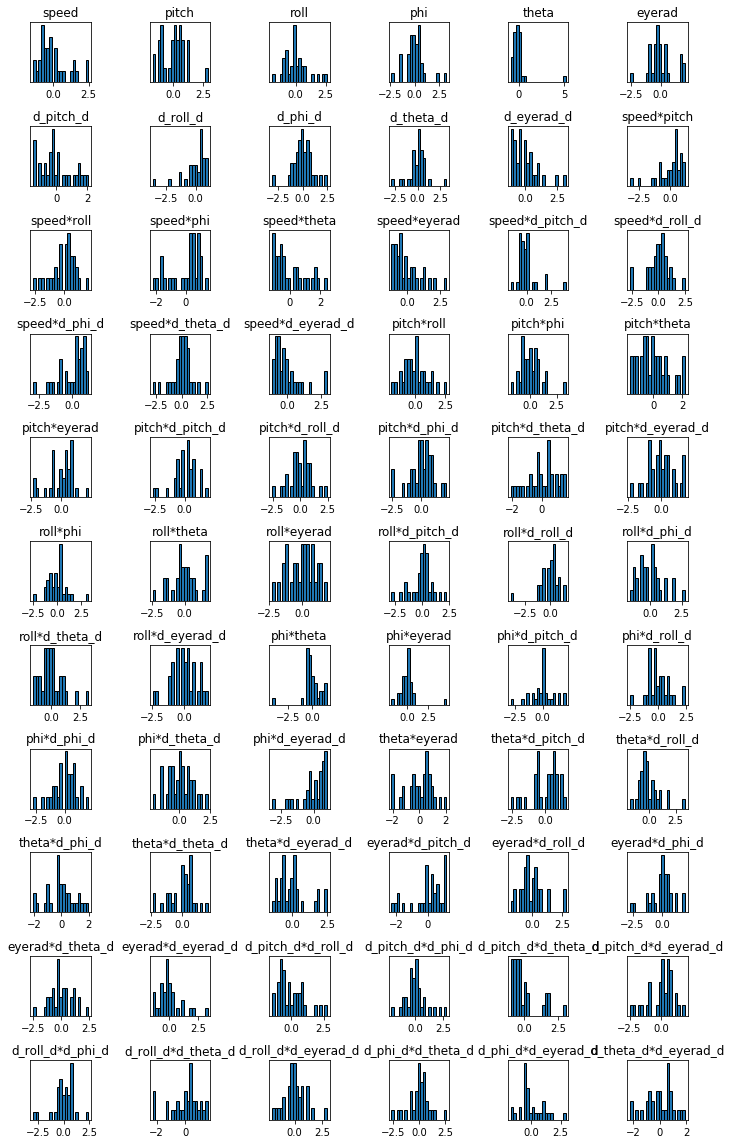

In [8]:
beh_var = load_saliency(path_beh, n_neur, std_per_var=std_per_var)
fig, axes = plt.subplots(ncols=6, nrows=11, figsize=(10, 16))
for i, ax in enumerate(axes.ravel()):
    if i >= n_beh_vars:
        break
    ax.hist(beh_var[:, i], bins=21, ec='k')
#     ax.set_xticks([-2, -1, 0, 1, 2])
#     ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_title(beh_name[i])
fig.tight_layout()

# How strongly are the behavioral variables encoded?

(32, 66) 32 66


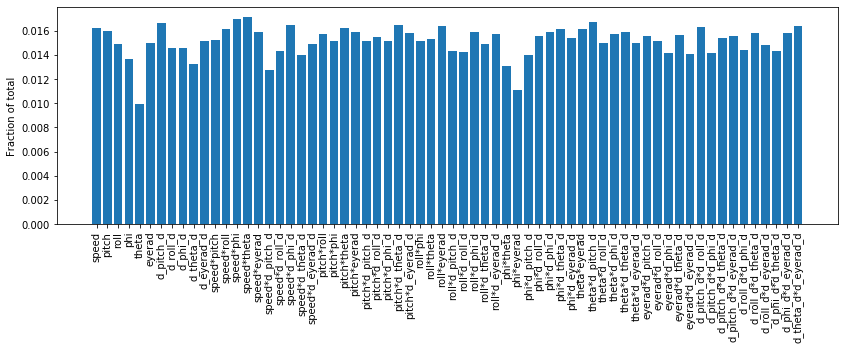

In [9]:
# Sum up the activation values (abs) for each variable
# Is meaningless if standardized individually
beh_var = load_saliency(path_beh, n_neur, std_per_var=std_per_var)
fig, ax = plt.subplots(figsize=(14, 4))
beh_act = np.sum(np.abs(beh_var), axis=0)
ax.bar(np.arange(n_beh_vars), beh_act / np.sum(beh_act))
ax.set_ylabel('Fraction of total')
ax.set_xticks(np.arange(n_beh_vars))
ax.set_xticklabels(beh_name, rotation=90);

# How often are the behavioral variables encoded?

(32, 66) 32 66


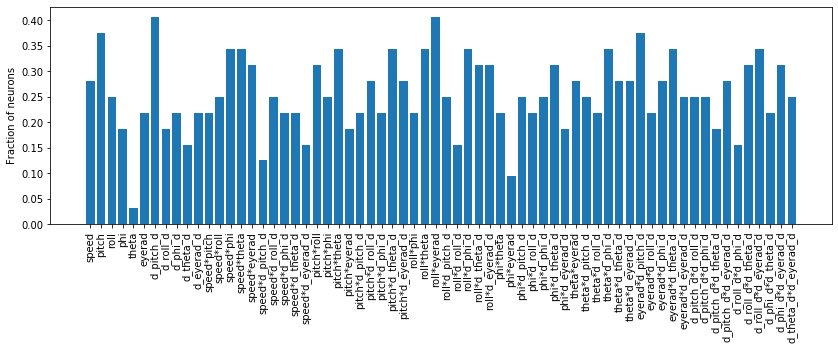

In [10]:
beh_var = load_saliency(path_beh, n_neur, std_per_var=std_per_var)
fig, ax = plt.subplots(figsize=(14, 4))
ax.bar(np.arange(n_beh_vars), np.sum(np.abs(beh_var) >= th, axis=0) / n_neur)
ax.set_ylabel('Fraction of neurons')
ax.set_xticks(np.arange(n_beh_vars))
ax.set_xticklabels(beh_name, rotation=90);

In [11]:
th = 1

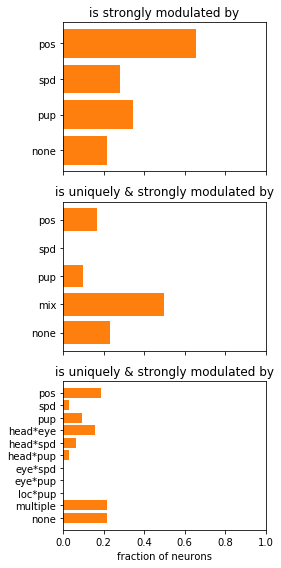

In [12]:
fig, axes = plt.subplots(ncols=1, nrows=3, figsize=(4, 8), sharex=True)

stats = {
    'none': 0,
    'pup': 0,
    'spd': 0,
    'pos': 0,
}
for n in range(n_neur):
    # Pure responses
    is_hed = np.any(np.abs(beh_var[n, search_idx(head, beh_name, derivatives=True)]) >= th)
    is_eye = np.any(np.abs(beh_var[n, search_idx(eye, beh_name, derivatives=True)]) >= th)
    is_spd = np.any(np.abs(beh_var[n, search_idx(loco, beh_name, derivatives=True)]) >= th)
    is_pup = np.any(np.abs(beh_var[n, search_idx(arousal, beh_name, derivatives=True)]) >= th)
    
    stats['pos'] += int(is_hed or is_eye)
    stats['spd'] += int(is_spd)
    stats['pup'] += int(is_pup)
    stats['none'] += int(~np.any([is_hed, is_eye, is_spd, is_pup]))
        
# assert sum(stats.values()) == n_good_neur

if "LT" in mouse:
    axes[0].barh([0], [0])
if "NC" in mouse:
    axes[0].barh([0], [0])
    axes[0].barh([0], [0])
axes[0].barh(np.arange(len(stats)), np.array(list(stats.values())) / n_neur)  #np.sum(list(stats.values())))
axes[0].set_yticks(np.arange(len(stats)))
axes[0].set_yticklabels(list(stats.keys()), rotation=0)
axes[0].set_title('is strongly modulated by')


stats = {
    'none': 0,
    'mix': 0,
    'pup': 0,
    'spd': 0,
    'pos': 0,
}
for n in range(n_neur):
    if corr_beh[0][n] < corr_th:
        continue
    
    # Pure responses
    is_hed = np.any(np.abs(beh_var[n, search_idx(head, beh_name, derivatives=True)]) >= th)
    is_eye = np.any(np.abs(beh_var[n, search_idx(eye, beh_name, derivatives=True)]) >= th)
    is_spd = np.any(np.abs(beh_var[n, search_idx(loco, beh_name, derivatives=True)]) >= th)
    is_pup = np.any(np.abs(beh_var[n, search_idx(arousal, beh_name, derivatives=True)]) >= th)
    if not np.any([is_hed, is_eye, is_spd, is_pup]):
        stats['none'] += 1
    elif is_hed and not np.any([is_eye, is_spd, is_pup]):
        stats['pos'] += 1
    elif is_eye and not np.any([is_hed, is_spd, is_pup]):
        stats['pos'] += 1
    elif is_spd and not np.any([is_eye, is_hed, is_pup]):
        stats['spd'] += 1
    elif is_pup and not np.any([is_eye, is_hed, is_spd]):
        stats['pup'] += 1
    else:
        stats['mix'] += 1
        
assert sum(stats.values()) == n_good_neur

if "LT" in mouse:
    axes[1].barh([0], [0])
if "NC" in mouse:
    axes[1].barh([0], [0])
    axes[1].barh([0], [0])
axes[1].barh(np.arange(len(stats)), np.array(list(stats.values())) / n_good_neur)
axes[1].set_yticks(np.arange(len(stats)))
axes[1].set_yticklabels(list(stats.keys()), rotation=0);
axes[1].set_title('is uniquely & strongly modulated by')


stats = {
    'none': 0,
    'multiple': 0,
    'loc*pup': 0,
    'eye*pup': 0,
    'eye*spd': 0,
    'head*pup': 0,
    'head*spd': 0,
    'head*eye': 0,
    'pup': 0,
    'spd': 0,
    'pos': 0,
}
for n in range(n_neur):
    # Pure responses
    is_hed = np.any(np.abs(beh_var[n, search_idx(head, beh_name, derivatives=True)]) >= th)
    is_eye = np.any(np.abs(beh_var[n, search_idx(eye, beh_name, derivatives=True)]) >= th)
    is_loc = np.any(np.abs(beh_var[n, search_idx(loco, beh_name, derivatives=True)]) >= th)
    is_pup = np.any(np.abs(beh_var[n, search_idx(arousal, beh_name, derivatives=True)]) >= th)
    if not np.any([is_hed, is_eye, is_loc, is_pup]):
        stats['none'] += 1
    elif is_hed and not np.any([is_eye, is_loc, is_pup]):
        stats['pos'] += 1
    elif is_eye and not np.any([is_hed, is_loc, is_pup]):
        stats['pos'] += 1
    elif is_loc and not np.any([is_eye, is_hed, is_pup]):
        stats['spd'] += 1
    elif is_pup and not np.any([is_eye, is_hed, is_loc]):
        stats['pup'] += 1
    elif is_hed and is_eye and not np.any([is_loc, is_pup]):
        stats['head*eye'] += 1
    elif is_hed and is_loc and not np.any([is_eye, is_pup]):
        stats['head*spd'] += 1
    elif is_hed and is_pup and not np.any([is_eye, is_loc]):
        stats['head*pup'] += 1
    elif is_eye and is_loc and not np.any([is_hed, is_pup]):
        stats['eye*spd'] += 1
    elif is_eye and is_pup and not np.any([is_hed, is_loc]):
        stats['eye*pup'] += 1
    elif is_loc and is_pup and not np.any([is_hed, is_eye]):
        stats['loc*pup'] += 1
    else:
        stats['multiple'] += 1

if "LT" in mouse:
    axes[2].barh([0], [0])
if "NC" in mouse:
    axes[2].barh([0], [0])
    axes[2].barh([0], [0])

axes[2].barh(np.arange(len(stats)), np.array(list(stats.values())) / n_neur)
axes[2].set_yticks(np.arange(len(stats)))
axes[2].set_yticklabels(list(stats.keys()), rotation=0);
axes[2].set_title('is uniquely & strongly modulated by')
axes[2].set_xlim(0, 1)

axes[2].set_xlabel('fraction of neurons')

fig.tight_layout()

fig.savefig(f"fig-behavioral-{mouse}.pdf", transparent=True)